In [113]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from collections import Counter

from sklearn.metrics import auc, precision_score, recall_score, f1_score

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1

In [12]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

In [13]:
COLS = ['Make','Model','Year', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Vehicle Style',
       'highway MPG', 'city mpg',  'MSRP']

data = data[COLS]
data.columns = [name.lower().replace(' ','_') for name in data.columns]

data = data.fillna(0)
data['price'] = data['msrp']
data['above_average'] = np.where(data['price'] > data['price'].mean(), 1, 0) * 1

In [14]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp` +
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [17]:
data_num = data.select_dtypes(np.number)

In [18]:
data_num.columns

Index(['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg',
       'msrp', 'price', 'above_average'],
      dtype='object')

In [46]:
for col in ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']:
    score = roc_auc_score(df_train['above_average'],df_train[col])
    if score <0.5:
        score = roc_auc_score(-df_train['above_average'],df_train[col])
    print(score, col )

0.9162324220917971 engine_hp
0.7674408924408924 engine_cylinders
0.6351930621461872 highway_mpg
0.6754616043678544 city_mpg


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878 ?? + 
- 0.979

In [68]:
X_cols = ['make', 'model', 'year',  'engine_hp',
       'engine_cylinders', 'transmission_type', 'vehicle_style',
       'highway_mpg','city_mpg']
TARGET = 'above_average'

In [69]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train[X_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[X_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[X_cols].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [88]:
model = LogisticRegression(solver='liblinear', C=1, max_iter=1000,)
model.fit(X_train, df_train[TARGET])

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [89]:
roc_auc_score(df_val[TARGET], model.predict(X_val))

0.9177639358688776

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48 +
* 0.68
* 0.88

In [78]:
recall_scores = []
precision_scores = []

for i in np.linspace(0,1,50):
    prec = precision_score(df_val[TARGET], (model.predict_proba(X_val)[:,1] >i)*1)
    recall = recall_score(df_val[TARGET], (model.predict_proba(X_val)[:,1] >i)*1)
    precision_scores.append(prec)
    recall_scores.append(recall)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


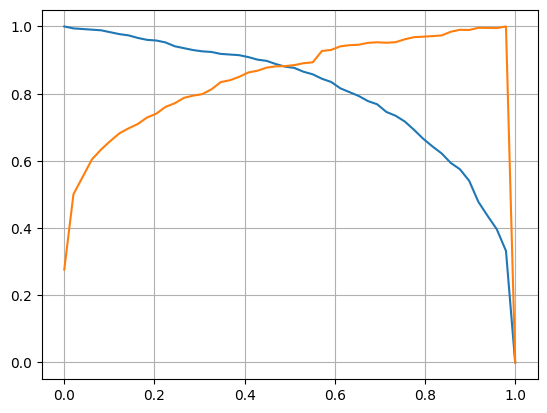

In [82]:
plt.plot(np.linspace(0,1,50), recall_scores)
plt.plot(np.linspace(0,1,50), precision_scores)
plt.grid()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52 +
- 0.72


In [93]:
f1_scores = []

for i in np.linspace(0,1,101):
    f1 = f1_score(df_val[TARGET], (model.predict_proba(X_val)[:,1] >i)*1)
   
    f1_scores.append(f1)

In [94]:
np.argmax(f1_scores)

46

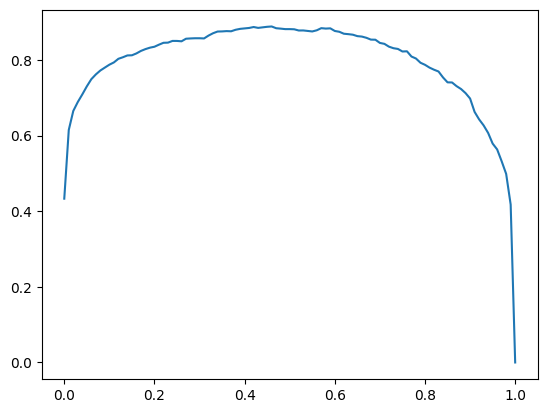

In [96]:
plt.plot(np.linspace(0,1,101), f1_scores)

In [97]:
f1_scores[11], f1_scores[31], f1_scores[51], f1_scores[71], 

(0.7932359723289777,
 0.8566402814423921,
 0.8808388941849381,
 0.8423280423280424)

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003 +
- 0.030
- 0.090
- 0.140


In [98]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [104]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[X_cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000, solver = 'liblinear')
    model.fit(X_train, y_train)
    
    return dv, model
def predict(df, dv, model):
    dicts = df[X_cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [111]:
scores = []
stds= []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train[TARGET]
    y_val = df_val[TARGET]

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    stds.append(np.std(y_pred))
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.979 +- 0.003


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10 +

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [115]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train[TARGET]
        y_val = df_val[TARGET]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.16s/it]

C=0.01 0.952 +- 0.002


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.16s/it]

C=0.1 0.972 +- 0.002


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.16s/it]

C=0.5 0.978 +- 0.001


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.18s/it]

C=10 0.983 +- 0.003
